# Proceso Carga base de datos en nube DigitalOcean

## Realizamos la carga de la base de datos en la nube DigitalOcean


En el proceso de migración y carga de datos a la nube de DigitalOcean, hemos aprovechado las ventajas de utilizar Prefect, una herramienta de orquestación de flujos de trabajo de código abierto.

Gracias a Prefect, pudimos automatizar y gestionar de manera eficiente el flujo de datos desde nuestras bases de datos locales hasta la nube, asegurando la integridad, disponibilidad y confidencialidad de la información en todo momento. Además, su interfaz gráfica nos permitió visualizar y monitorear el progreso de la migración en tiempo real.

La información subida a la nube incluye datos clave para la operación, planificación y análisis del sistema eléctrico colombiano, como la generación, transmisión, distribución y consumo de energía eléctrica en todo el país. Al contar con esta información en la nube, podemos aprovechar la escalabilidad y flexibilidad que ofrece DigitalOcean para adaptarnos a las necesidades cambiantes del sector.

En definitiva, la utilización de Prefect en el proceso de migración a la nube de DigitalOcean ha sido un factor clave para asegurar la eficiencia, seguridad y confiabilidad de la gestión de datos del sistema eléctrico colombiano.

In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine
from prefect import task, flow
import time

# Variables de Entorno de la base de datos
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

Gestión para los campos tipo datetime si es una columna de fechas y convertir el archivo .JSON y convertirlo en un dataframe de pandas

In [ ]:
# Ruta a la carpeta con archivos JSON
folder_path = './data/'

def convertir_a_numerico(columna):
    # Intentar convertir a datetime para detectar si es una columna de fechas
    try:
        pd.to_datetime(columna)
        return columna  # Si no hay error, es una columna de fechas, devolverla sin cambios
    except (ValueError, TypeError):
        # Intentar convertir a numérico si no es una columna de fechas
        try:
            return pd.to_numeric(columna)
        except ValueError:
            return columna

@task
def list_files(folder_path):
    """Lista todos los archivos JSON en la carpeta especificada."""
    files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    return files

@task
def read_json_file(file_path):
    """Lee un archivo JSON y lo convierte en un DataFrame de pandas."""
    df = pd.read_json(file_path, lines=True)
    df = df.apply(convertir_a_numerico)
    return df

Cargamos el dataframe en una tabla de base de datos postgres

In [ ]:
@task
def load_to_postgres(df, table_name):
    """Carga un DataFrame en una tabla PostgreSQL."""
    start_time = time.time()
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f'Tabla {table_name} cargada con éxito en {execution_time:.4f} segundos.')

Se obtiene el nombre de la tabla a partir del nombre del archivo 

In [ ]:
@task
def get_table_name(file_name):
    """Obtiene el nombre de la tabla a partir del nombre del archivo."""
    return os.path.splitext(file_name)[0]


Obtenemos la ruta del archivo y creamos la función del flujo de carga

In [ ]:
@task
def get_file_path(folder_path, file_name):
    """Obtiene la ruta completa del archivo."""
    return os.path.join(folder_path, file_name)

@flow
def flujo_carga():
    files = list_files(folder_path)
    for file_name in files:
        file_path = get_file_path(folder_path, file_name)
        df = read_json_file(file_path)
        table_name = get_table_name(file_name)
        load_to_postgres(df, table_name)

if __name__=="__main__":
    flujo_carga()


## Resultado y confirmación del proceso mediante Prefect

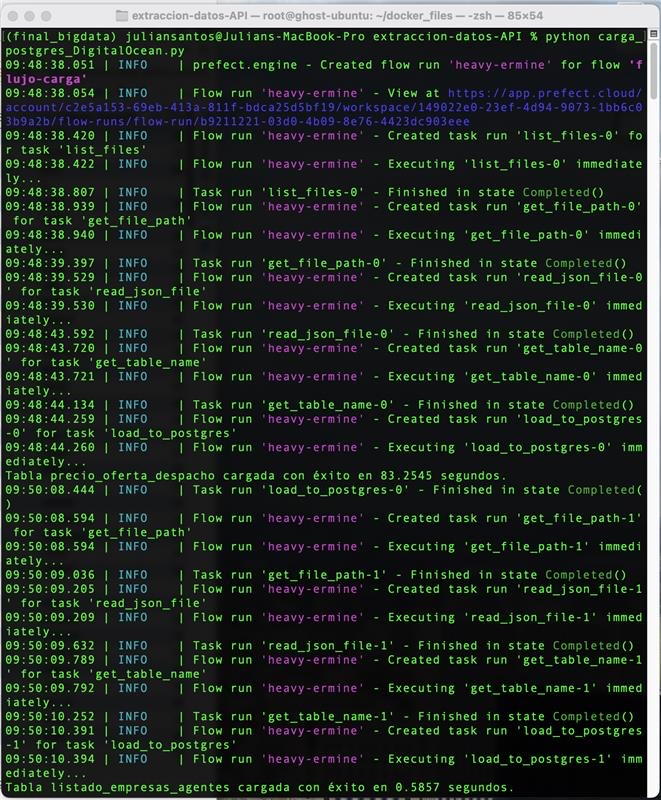

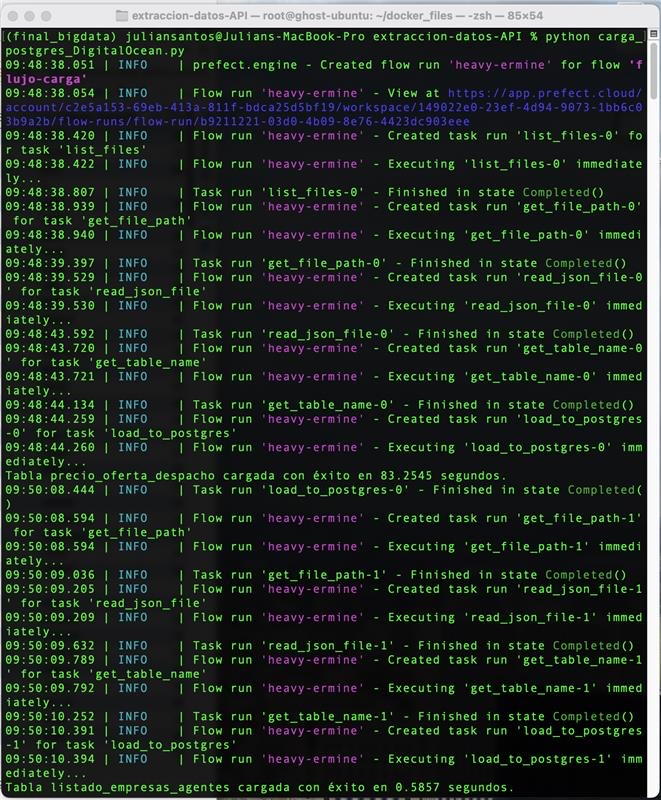

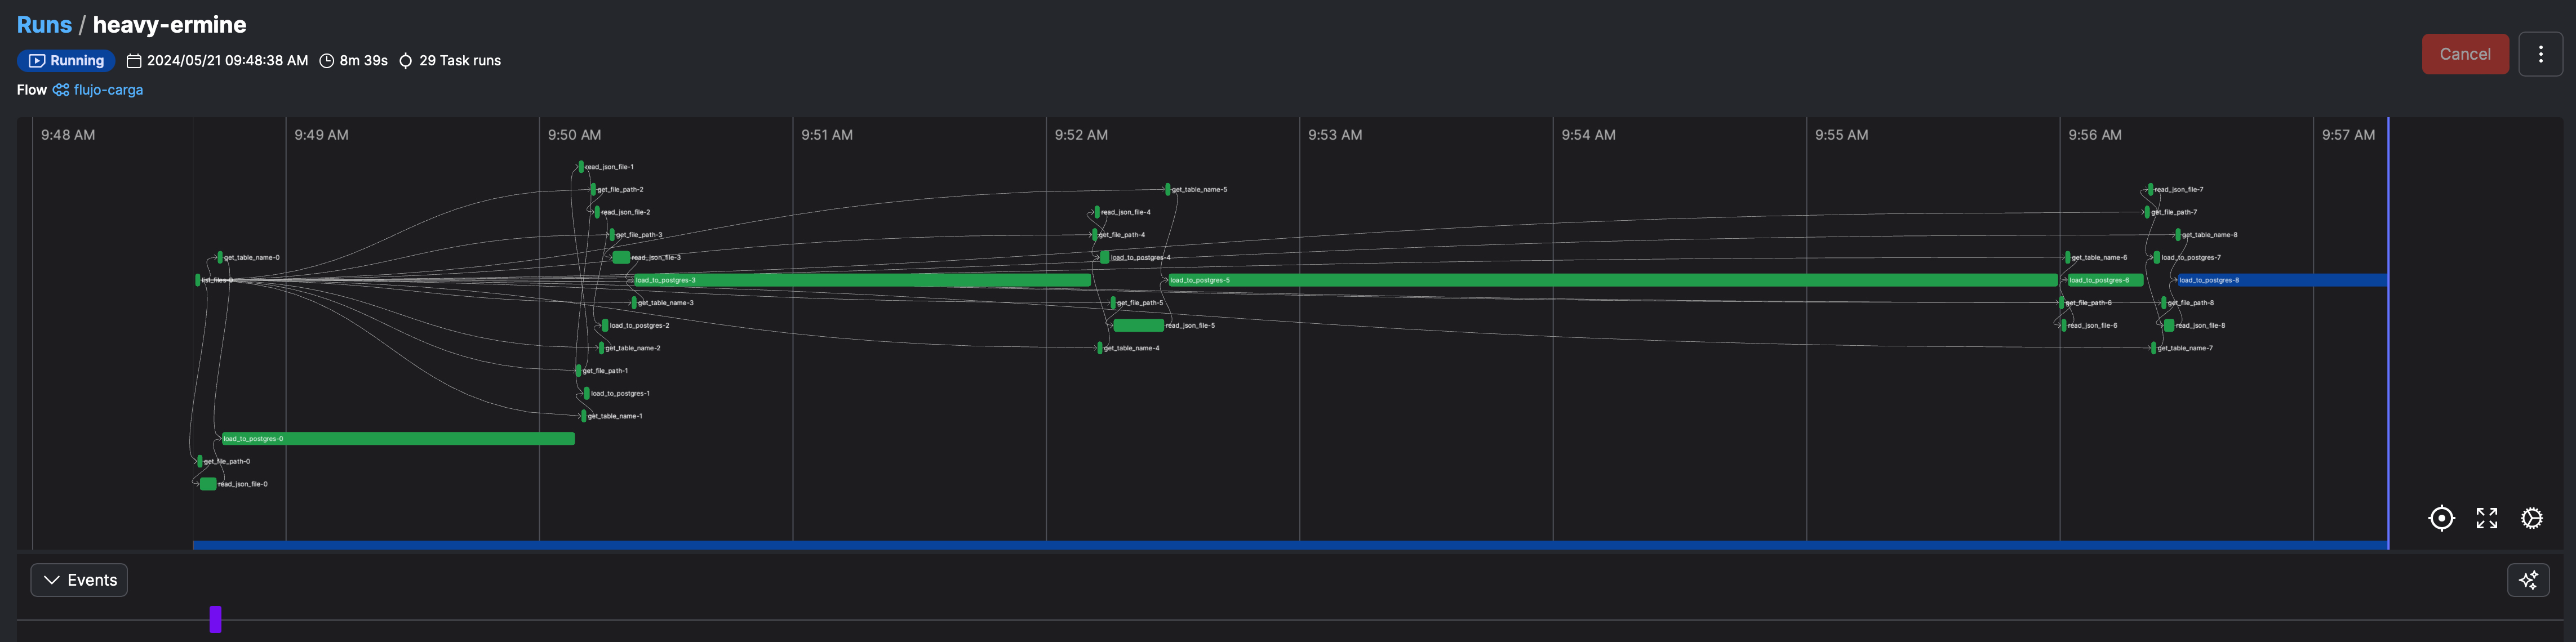